# Ever Delinquent Prediction Write Up

##  Problem Statement and Summary of Key Results

The goal of this project is to predict ever-delinquent probabilities on 481,218 Radian insured loans during time period 2010 - 2013, based on a handful of loan characteristics. With the predicted delinquency probablity, Radian could benefit from properly price the loan (the riskier the loans, the higher the premium), hence determine the risk inforce $ amount as well as reserve amount.

The key takeaways are as follows:

1) This is a typical classification problem. Among different machine learning algorithms (Logistic Regression, SVM, Kernel SVM, Random Forest and Decision Tree) I tried for this project, logistic regression outperformed the rest with 68.5% AUC ROC score. In other words, 68.5% of the time the ever deliquency prediction is accurate among sample populations. It is around average accuracy rate after I communicated with our internal modeling team.

2) Loan characteristics such as FICO, DTI, LTV, Number of Borrowers, Property Type, Occupancy Status, First-time Home Buyer (Y/N) and Loan Purpose are selected features in my predictive model. In other words, when given these loan characteristics during underwriting process, Radian will know upfront how likely the loans will end up in ever-delinquent status, thus providing lenders the pricing option based on pricing scorecard.

3) The outcome of the predictive model could also be used in calculating reserve amount on a given loan. Below is just a simplified calculation, and in real world, we will also consider other factors such as reinsurance deals, REO, claim documents completeness etc. 

$$Rserve $ Amount = Original~UPB * MI~Coverage * Ever~Delinquent~Probability * Claim~Probability~on~Ever~Delinquent$$

## Data Exploration and Feature Selection

I pulled the base population from Radian's database with the following criteria:
- Vintage loans closed after 2010 to avoid financial crisis (2007-2008) which can be the noise in the predictive model.
- Vintage loans closed before 2013 so that there are enough time to see their performance until now.

There are 481,218 loans in total from my data pull.
- **10 features** were chosen during DEA step, **7** of which are categorical data. The reasons I dropped the rest columns are due to *1) unique indentifier column such as loan number 2) values under the columns are almost identical (>99%).* See the summary table of the selected features' distribution below:


| Orig Yr| % to All   |Claim %|
|--------------|-----------|---------|
|2010        |   10.6%   |0.6%
|2011       |   15.0%   |0.3%
|2012       |   34.5%   |0.1%
|2013       |   40.0%   |0.1%

| Loan Purp     | % to All  
|--------------|-----------
| Refi Cash Out       |   2.6%   
| Refi Payoff Lien      |  32.4%   
| Purchase    |  65.1%   

| Property Type     | % to All  
|--------------|-----------
| Co-op or Condo       |   9.8%   
| Manufacutre Housing    |  0.3%   
| Single Fam    |  89.9%   

| Occupancy Status     | % to All  
|--------------|-----------
| Primary Resident     |   96.5%   
| Secondary Resident    |  3.5% 

| First Time Home Buyer     | % to All  
|--------------|-----------
| Y     |   31.7%   
| N    |  68.3% 

| Multi Borrower    | % to All  
|--------------|-----------
| Y     |   49.2%   
| N    |  50.8% 

| MI Channel    | % to All  
|--------------|-----------
| Delegated     |   66.7%   
| Non-Delegated    |  33.3% 

- Another **3** features (FICO, DTI and LTV) are continuous data originally. However, in order to make dummy variable creation later on more doable, I slightly manipulated the data and grouped the values into different buckets. Now those 3 features become categorical data as well.

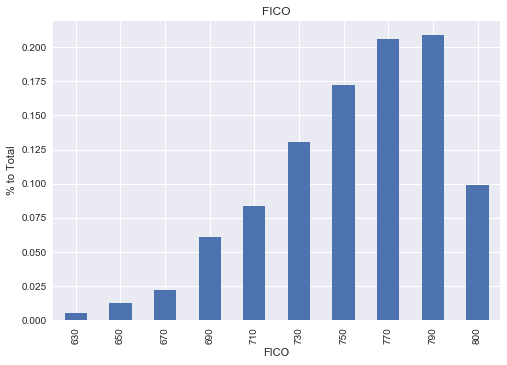
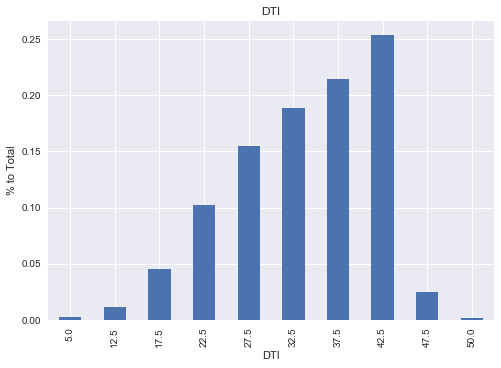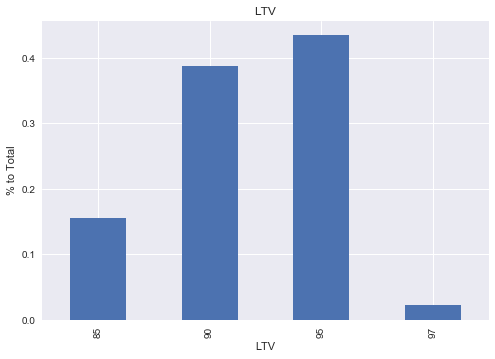

- I also downsampled the "never deliquent" loans from the entire population due to skewed data (2.5% delinquent vs. 97.5% never delinquent loans). So before creating the model, I modified the population (training and test set combined) to 10,000 : **5,000 never delinquent and 5,000 ever delinquent**.

## Model Fitting and Regularization

Logistic Regression outperformed SVM, Decision Tree and Random Forest algorithms in predicting ever-delinquent probablities and resulted in **68.6% accuracy score**. See below as the outcome from Logistic Regression.

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from ggplot import *
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
df_eval = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df_eval, aes(x='fpr', y='tpr')) +\
      geom_line() +\
      geom_abline(linetype='dashed')

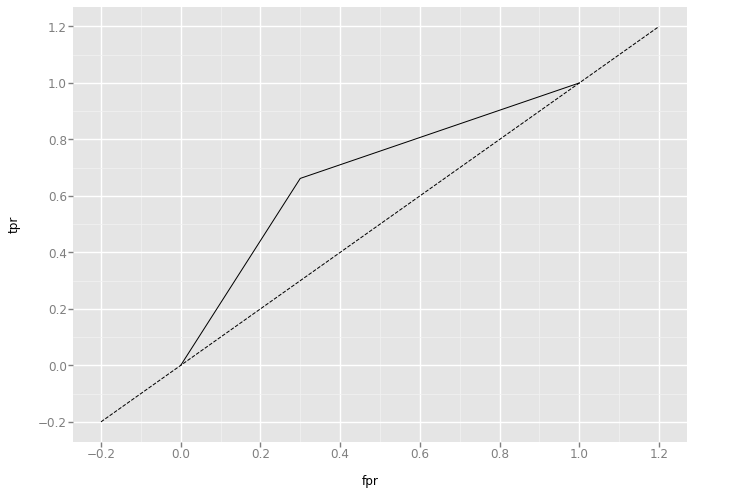

In [ ]:
# Applying K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies1 = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
#mean
accuracies1.mean()
#variance
accuracies1.std()

accuracy mean: 0.68612388710894023
accuracy std: 0.013107884669360552

I also performed Lasso (L1) and Ridge (L2) regularization after fitting the training set in the model. It turns out the accuracy is very close to the one before regularization. 

In [ ]:
# Fitting Logistic Regression with Regularization to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty = 'l2', C =100,random_state = 0)
classifier.fit(X_train, y_train)
# Applying K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies1 = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies1.mean()

accuracy: 0.68537408215296181

##### I will add the bell curve charts later after we discuss the message. I cannot fully getting what I see.

## Next Steps/Future Works

- Create utility codes for future use: model fitting, model evaluation and regularization pieces 
- This model is under a fairly simplified assumpsion that ever-delinquent relate to claim rate. But in the real world, a loan's claim status is also related to how long a loan gets into delinquent (60-days, 120-days. 360-days etc.) and how often a loan gets into delinquent. The transactional data will be helpful to answer this question. 
- Some other features might be relevant in predicting ever delinquent probablity: property state, property value, borrower years of employment, self-employed Y/N etc. Some of the data is not available for me to use today, but it is not a bad idea to put my thoughts out there. 